# Pipeline For Football Result Forecasting

## Combine CSVs

In [41]:
# Core packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    f1_score,
    root_mean_squared_error,
    r2_score
)
from sklearn.decomposition import PCA
from sklearn.utils import resample

In [2]:
def append_csvs_in_folder(folder_path, output_file):
    combined_df = pd.DataFrame()
    
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):  
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path)
            combined_df = pd.concat([combined_df, df], ignore_index=True)
    
    combined_df.to_csv(output_file, index=False)
    print(f"Combined file saved to: {output_file}")

folder_path = '../data'
output_file = '../processed_data/matches.csv'
append_csvs_in_folder(folder_path, output_file)

Combined file saved to: ../processed_data/matches.csv


## Cleansing

In [2]:
file_path = "../processed_data/matches.csv"
data = pd.read_csv(file_path)

initial_row_count = data.shape[0]

required_columns = [
    'home_team_name', 'away_team_name',
    'home_team_goal_count', 'away_team_goal_count',
    'team_a_xg', 'team_b_xg',
    'home_team_shots', 'away_team_shots',
    'home_team_shots_on_target', 'away_team_shots_on_target',
    'home_team_possession', 'away_team_possession',
    'home_team_yellow_cards', 'away_team_yellow_cards',
    'home_team_red_cards', 'away_team_red_cards',
    'date_GMT',
    'odds_ft_home_team_win', 'odds_ft_draw', 'odds_ft_away_team_win'
]

numeric_cols = [
    'home_team_goal_count', 'away_team_goal_count',
    'team_a_xg', 'team_b_xg',
    'home_team_shots', 'away_team_shots',
    'home_team_shots_on_target', 'away_team_shots_on_target',
    'home_team_possession', 'away_team_possession',
    'home_team_yellow_cards', 'away_team_yellow_cards',
    'home_team_red_cards', 'away_team_red_cards',
    'odds_ft_home_team_win', 'odds_ft_draw', 'odds_ft_away_team_win'
]

data = data[data['status'].str.lower() == 'complete']

non_numeric_required = list(set(required_columns) - set(numeric_cols))
data = data.dropna(subset=non_numeric_required)

data['date_GMT'] = pd.to_datetime(data['date_GMT'], format="%b %d %Y - %I:%M%p", errors='coerce')
data = data.dropna(subset=['date_GMT'])

data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric, errors='coerce')

data = data.dropna(subset=numeric_cols)

data = data[~((data['team_a_xg'] == 0) & (data['team_b_xg'] == 0))]

data = data.sort_values(by='date_GMT').reset_index(drop=True)

final_row_count = data.shape[0]
rows_dropped = initial_row_count - final_row_count

cleaned_file_path = "../processed_data/matches_cleansed.csv"
data.to_csv(cleaned_file_path, index=False)

print(f"Cleaned data saved to {cleaned_file_path}")
print(f"Rows remaining: {final_row_count}")
print(f"Rows dropped: {rows_dropped}")


Cleaned data saved to ../processed_data/matches_cleansed.csv
Rows remaining: 18904
Rows dropped: 2127


## Feature Generation

In [4]:
file_path = "../processed_data/matches_cleansed.csv"
data = pd.read_csv(file_path)
data = data.sort_values(by='date_GMT').reset_index(drop=True)

team_stats = {}
initial_elo = 1500
k_factor = 20

def get_match_result(row):
    if row['home_team_goal_count'] > row['away_team_goal_count']:
        return 0  # Home win
    elif row['home_team_goal_count'] < row['away_team_goal_count']:
        return 2  # Away win
    else:
        return 1  # Draw

def get_k_factor(goal_diff):
    if goal_diff == 0:
        return 20
    elif goal_diff == 1:
        return 25
    elif goal_diff == 2:
        return 30
    else:
        return 35

def update_elo(rating_a, rating_b, result, k):
    expected_a = 1 / (1 + 10 ** ((rating_b - rating_a) / 400))
    rating_a_new = rating_a + k * (result - expected_a)
    rating_b_new = rating_b + k * ((1 - result) - (1 - expected_a))
    return rating_a_new, rating_b_new

def update_rolling(stat_list, value, max_len=30):
    if len(stat_list) == max_len:
        stat_list.pop(0)
    stat_list.append(value)

data['match_result'] = data.apply(get_match_result, axis=1)
data['is_first_game'] = False

columns = [
    'home_team_avg_xg', 'away_team_avg_xg',
    'home_team_avg_xg_against', 'away_team_avg_xg_against',
    'home_team_ppg', 'away_team_ppg',
    'home_team_avg_goals_scored', 'away_team_avg_goals_scored',
    'home_team_avg_goals_against', 'away_team_avg_goals_against',
    'home_team_avg_shots_for', 'away_team_avg_shots_for',
    'home_team_avg_shots_against', 'away_team_avg_shots_against',
    'home_team_avg_shots_on_target', 'away_team_avg_shots_on_target',
    'home_team_avg_shots_on_target_against', 'away_team_avg_shots_on_target_against',
    'home_team_avg_pos', 'away_team_avg_pos',
    'home_team_avg_yellow', 'away_team_avg_yellow',
    'home_team_avg_red', 'away_team_avg_red',
    'home_team_last_5_avg_xg', 'away_team_last_5_avg_xg',
    'home_team_last_5_avg_xg_against', 'away_team_last_5_avg_xg_against',
    'home_team_last_5_avg_points', 'away_team_last_5_avg_points',
    'home_team_last_5_avg_goals_scored', 'away_team_last_5_avg_goals_scored',
    'home_team_last_5_avg_goals_against', 'away_team_last_5_avg_goals_against',
    'home_team_last_5_avg_shots_for', 'away_team_last_5_avg_shots_for',
    'home_team_last_5_avg_shots_against', 'away_team_last_5_avg_shots_against',
    'home_team_last_5_avg_shots_on_target', 'away_team_last_5_avg_shots_on_target',
    'home_team_last_5_avg_shots_on_target_against', 'away_team_last_5_avg_shots_on_target_against',
    'home_team_last_5_avg_pos', 'away_team_last_5_avg_pos',
    'home_team_last_5_avg_yellow', 'away_team_last_5_avg_yellow',
    'home_team_last_5_avg_red', 'away_team_last_5_avg_red',
    'home_team_elo', 'away_team_elo',
    'hometeam_ppg_vs_awayteam', 'awayteam_ppg_vs_hometeam',
    'hometeamgoals_vs_awayteam', 'awayteamgoals_vs_hometeam'
]

for col in columns:
    data[col] = 0.0

for index, row in data.iterrows():
    home_team = row['home_team_name']
    away_team = row['away_team_name']

    for team in [home_team, away_team]:
        if team not in team_stats:
            team_stats[team] = {
                'xg': [], 'xg_against': [], 'points': [],
                'goals_scored': [], 'goals_against': [],
                'shots_for': [], 'shots_against': [],
                'shots_on_target': [], 'shots_on_target_against': [],
                'pos': [], 'yellow': [], 'red': [],
                'elo': initial_elo, 'opponents': {}
            }

    home_stats = team_stats[home_team]
    away_stats = team_stats[away_team]

    for a, b in [(home_team, away_team), (away_team, home_team)]:
        if b not in team_stats[a]['opponents']:
            team_stats[a]['opponents'][b] = {'points': [], 'goals_for': [], 'goals_against': []}

    if not home_stats['xg'] or not away_stats['xg']:
        data.at[index, 'is_first_game'] = True
        home_points = 3 if row['home_team_goal_count'] > row['away_team_goal_count'] else (1 if row['home_team_goal_count'] == row['away_team_goal_count'] else 0)
        away_points = 3 if row['away_team_goal_count'] > row['home_team_goal_count'] else (1 if row['home_team_goal_count'] == row['away_team_goal_count'] else 0)

        home_stats['xg'].append(row['team_a_xg'])
        away_stats['xg'].append(row['team_b_xg'])
        home_stats['xg_against'].append(row['team_b_xg'])
        away_stats['xg_against'].append(row['team_a_xg'])

        home_stats['points'].append(home_points)
        away_stats['points'].append(away_points)

        home_stats['goals_scored'].append(row['home_team_goal_count'])
        home_stats['goals_against'].append(row['away_team_goal_count'])
        away_stats['goals_scored'].append(row['away_team_goal_count'])
        away_stats['goals_against'].append(row['home_team_goal_count'])

        home_stats['shots_for'].append(row['home_team_shots'])
        home_stats['shots_against'].append(row['away_team_shots'])
        home_stats['shots_on_target'].append(row['home_team_shots_on_target'])
        home_stats['shots_on_target_against'].append(row['away_team_shots_on_target'])

        away_stats['shots_for'].append(row['away_team_shots'])
        away_stats['shots_against'].append(row['home_team_shots'])
        away_stats['shots_on_target'].append(row['away_team_shots_on_target'])
        away_stats['shots_on_target_against'].append(row['home_team_shots_on_target'])

        home_stats['pos'].append(row['home_team_possession'])
        away_stats['pos'].append(row['away_team_possession'])

        home_stats['yellow'].append(row['home_team_yellow_cards'])
        home_stats['red'].append(row['home_team_red_cards'])
        away_stats['yellow'].append(row['away_team_yellow_cards'])
        away_stats['red'].append(row['away_team_red_cards'])

        home_team_elo = home_stats['elo']
        away_team_elo = away_stats['elo']
        result = 1 if home_points == 3 else (0.5 if home_points == 1 else 0)

        goal_diff = abs(row['home_team_goal_count'] - row['away_team_goal_count'])
        k = get_k_factor(goal_diff)
        new_home_elo, new_away_elo = update_elo(home_team_elo, away_team_elo, result, k)
        
        home_stats['elo'], away_stats['elo'] = new_home_elo, new_away_elo

        home_stats['opponents'][away_team]['points'].append(home_points)
        home_stats['opponents'][away_team]['goals_for'].append(row['home_team_goal_count'])
        home_stats['opponents'][away_team]['goals_against'].append(row['away_team_goal_count'])

        away_stats['opponents'][home_team]['points'].append(away_points)
        away_stats['opponents'][home_team]['goals_for'].append(row['away_team_goal_count'])
        away_stats['opponents'][home_team]['goals_against'].append(row['home_team_goal_count'])
        continue

    home_team_avg_xg = sum(home_stats['xg']) / len(home_stats['xg']) if home_stats['xg'] else 0
    away_team_avg_xg = sum(away_stats['xg']) / len(away_stats['xg']) if away_stats['xg'] else 0
    home_team_avg_xg_against = sum(home_stats['xg_against']) / len(home_stats['xg_against']) if home_stats['xg_against'] else 0
    away_team_avg_xg_against = sum(away_stats['xg_against']) / len(away_stats['xg_against']) if away_stats['xg_against'] else 0
    
    home_team_ppg = sum(home_stats['points']) / len(home_stats['points']) if home_stats['points'] else 0
    away_team_ppg = sum(away_stats['points']) / len(away_stats['points']) if away_stats['points'] else 0
    
    # Goals
    home_team_avg_goals_scored = sum(home_stats['goals_scored']) / len(home_stats['goals_scored']) if home_stats['goals_scored'] else 0
    home_team_avg_goals_against = sum(home_stats['goals_against']) / len(home_stats['goals_against']) if home_stats['goals_against'] else 0
    away_team_avg_goals_scored = sum(away_stats['goals_scored']) / len(away_stats['goals_scored']) if away_stats['goals_scored'] else 0
    away_team_avg_goals_against = sum(away_stats['goals_against']) / len(away_stats['goals_against']) if away_stats['goals_against'] else 0
    
    # Shots & SoT
    home_team_avg_shots_for = sum(home_stats['shots_for']) / len(home_stats['shots_for']) if home_stats['shots_for'] else 0
    home_team_avg_shots_against = sum(home_stats['shots_against']) / len(home_stats['shots_against']) if home_stats['shots_against'] else 0
    home_team_avg_shots_on_target = sum(home_stats['shots_on_target']) / len(home_stats['shots_on_target']) if home_stats['shots_on_target'] else 0
    home_team_avg_shots_on_target_against = sum(home_stats['shots_on_target_against']) / len(home_stats['shots_on_target_against']) if home_stats['shots_on_target_against'] else 0
    
    away_team_avg_shots_for = sum(away_stats['shots_for']) / len(away_stats['shots_for']) if away_stats['shots_for'] else 0
    away_team_avg_shots_against = sum(away_stats['shots_against']) / len(away_stats['shots_against']) if away_stats['shots_against'] else 0
    away_team_avg_shots_on_target = sum(away_stats['shots_on_target']) / len(away_stats['shots_on_target']) if away_stats['shots_on_target'] else 0
    away_team_avg_shots_on_target_against = sum(away_stats['shots_on_target_against']) / len(away_stats['shots_on_target_against']) if away_stats['shots_on_target_against'] else 0
    
    # Pos, Cards
    home_team_avg_pos = sum(home_stats['pos']) / len(home_stats['pos']) if home_stats['pos'] else 0
    away_team_avg_pos = sum(away_stats['pos']) / len(away_stats['pos']) if away_stats['pos'] else 0
    home_team_avg_yellow = sum(home_stats['yellow']) / len(home_stats['yellow']) if home_stats['yellow'] else 0
    away_team_avg_yellow = sum(away_stats['yellow']) / len(away_stats['yellow']) if away_stats['yellow'] else 0
    home_team_avg_red = sum(home_stats['red']) / len(home_stats['red']) if home_stats['red'] else 0
    away_team_avg_red = sum(away_stats['red']) / len(away_stats['red']) if away_stats['red'] else 0
    
    # --- H2H stats ---
    home_vs_away = home_stats['opponents'][away_team]
    away_vs_home = away_stats['opponents'][home_team]

    home_team_elo = home_stats['elo']
    away_team_elo = away_stats['elo']
    
    home_ppg_vs_away = sum(home_vs_away['points']) / len(home_vs_away['points']) if home_vs_away['points'] else 0
    away_ppg_vs_home = sum(away_vs_home['points']) / len(away_vs_home['points']) if away_vs_home['points'] else 0
    home_goals_vs_away = sum(home_vs_away['goals_for']) / len(home_vs_away['goals_for']) if home_vs_away['goals_for'] else 0
    away_goals_vs_home = sum(away_vs_home['goals_for']) / len(away_vs_home['goals_for']) if away_vs_home['goals_for'] else 0
    
    # --- Last 5 ---
    def last_5_avg(stat_list):
        return sum(stat_list[-5:]) / min(len(stat_list), 5) if stat_list else 0
    
    home_last_5 = {stat: last_5_avg(home_stats[stat]) for stat in ['xg', 'xg_against', 'points', 'goals_scored', 'goals_against',
                                                                    'shots_for', 'shots_against', 'shots_on_target', 'shots_on_target_against',
                                                                    'pos', 'yellow', 'red']}
    away_last_5 = {stat: last_5_avg(away_stats[stat]) for stat in home_last_5}
    
    # Averages
    data.at[index, 'home_team_avg_xg'] = home_team_avg_xg
    data.at[index, 'away_team_avg_xg'] = away_team_avg_xg
    data.at[index, 'home_team_avg_xg_against'] = home_team_avg_xg_against
    data.at[index, 'away_team_avg_xg_against'] = away_team_avg_xg_against
    data.at[index, 'home_team_ppg'] = home_team_ppg
    data.at[index, 'away_team_ppg'] = away_team_ppg
    data.at[index, 'home_team_avg_goals_scored'] = home_team_avg_goals_scored
    data.at[index, 'home_team_avg_goals_against'] = home_team_avg_goals_against
    data.at[index, 'away_team_avg_goals_scored'] = away_team_avg_goals_scored
    data.at[index, 'away_team_avg_goals_against'] = away_team_avg_goals_against
    data.at[index, 'home_team_avg_shots_for'] = home_team_avg_shots_for
    data.at[index, 'home_team_avg_shots_against'] = home_team_avg_shots_against
    data.at[index, 'home_team_avg_shots_on_target'] = home_team_avg_shots_on_target
    data.at[index, 'home_team_avg_shots_on_target_against'] = home_team_avg_shots_on_target_against
    data.at[index, 'away_team_avg_shots_for'] = away_team_avg_shots_for
    data.at[index, 'away_team_avg_shots_against'] = away_team_avg_shots_against
    data.at[index, 'away_team_avg_shots_on_target'] = away_team_avg_shots_on_target
    data.at[index, 'away_team_avg_shots_on_target_against'] = away_team_avg_shots_on_target_against
    data.at[index, 'home_team_avg_pos'] = home_team_avg_pos
    data.at[index, 'away_team_avg_pos'] = away_team_avg_pos
    data.at[index, 'home_team_avg_yellow'] = home_team_avg_yellow
    data.at[index, 'away_team_avg_yellow'] = away_team_avg_yellow
    data.at[index, 'home_team_avg_red'] = home_team_avg_red
    data.at[index, 'away_team_avg_red'] = away_team_avg_red
    
    # Last 5 form
    for stat, val in home_last_5.items():
        data.at[index, f'home_team_last_5_avg_{stat}'] = val
    for stat, val in away_last_5.items():
        data.at[index, f'away_team_last_5_avg_{stat}'] = val
    
    # Elo
    data.at[index, 'home_team_elo'] = home_team_elo
    data.at[index, 'away_team_elo'] = away_team_elo
    
    # H2H
    data.at[index, 'hometeam_ppg_vs_awayteam'] = home_ppg_vs_away
    data.at[index, 'awayteam_ppg_vs_hometeam'] = away_ppg_vs_home
    data.at[index, 'hometeamgoals_vs_awayteam'] = home_goals_vs_away
    data.at[index, 'awayteamgoals_vs_hometeam'] = away_goals_vs_home

    # Relative (difference) features
    data.at[index, 'xg_diff'] = home_team_avg_xg - away_team_avg_xg
    data.at[index, 'xg_against_diff'] = home_team_avg_xg_against - away_team_avg_xg_against
    data.at[index, 'ppg_diff'] = home_team_ppg - away_team_ppg
    data.at[index, 'goals_scored_diff'] = home_team_avg_goals_scored - away_team_avg_goals_scored
    data.at[index, 'goals_against_diff'] = home_team_avg_goals_against - away_team_avg_goals_against
    data.at[index, 'shots_diff'] = home_team_avg_shots_for - away_team_avg_shots_for
    data.at[index, 'shots_against_diff'] = home_team_avg_shots_against - away_team_avg_shots_against
    data.at[index, 'sot_diff'] = home_team_avg_shots_on_target - away_team_avg_shots_on_target
    data.at[index, 'sot_against_diff'] = home_team_avg_shots_on_target_against - away_team_avg_shots_on_target_against
    data.at[index, 'pos_diff'] = home_team_avg_pos - away_team_avg_pos
    data.at[index, 'yellow_diff'] = home_team_avg_yellow - away_team_avg_yellow
    data.at[index, 'red_diff'] = home_team_avg_red - away_team_avg_red
    data.at[index, 'elo_diff'] = home_team_elo - away_team_elo
    data.at[index, 'last5_points_diff'] = home_last_5['points'] - away_last_5['points']
    data.at[index, 'last5_goals_diff'] = home_last_5['goals_scored'] - away_last_5['goals_scored']
    data.at[index, 'last5_pos_diff'] = home_last_5['pos'] - away_last_5['pos']


    # Update rolling stats after each game

    # xG
    update_rolling(home_stats['xg'], row['team_a_xg'])
    update_rolling(away_stats['xg'], row['team_b_xg'])
    
    # xG Against
    update_rolling(home_stats['xg_against'], row['team_b_xg'])
    update_rolling(away_stats['xg_against'], row['team_a_xg'])
    
    # Points
    home_points = 3 if row['home_team_goal_count'] > row['away_team_goal_count'] else (
        1 if row['home_team_goal_count'] == row['away_team_goal_count'] else 0
    )
    away_points = 3 if row['away_team_goal_count'] > row['home_team_goal_count'] else (
        1 if row['home_team_goal_count'] == row['away_team_goal_count'] else 0
    )
    update_rolling(home_stats['points'], home_points)
    update_rolling(away_stats['points'], away_points)
    
    # Goals
    update_rolling(home_stats['goals_scored'], row['home_team_goal_count'])
    update_rolling(home_stats['goals_against'], row['away_team_goal_count'])
    update_rolling(away_stats['goals_scored'], row['away_team_goal_count'])
    update_rolling(away_stats['goals_against'], row['home_team_goal_count'])
    
    # Shots & Shots on Target
    update_rolling(home_stats['shots_for'], row['home_team_shots'])
    update_rolling(home_stats['shots_against'], row['away_team_shots'])
    update_rolling(home_stats['shots_on_target'], row['home_team_shots_on_target'])
    update_rolling(home_stats['shots_on_target_against'], row['away_team_shots_on_target'])
    
    update_rolling(away_stats['shots_for'], row['away_team_shots'])
    update_rolling(away_stats['shots_against'], row['home_team_shots'])
    update_rolling(away_stats['shots_on_target'], row['away_team_shots_on_target'])
    update_rolling(away_stats['shots_on_target_against'], row['home_team_shots_on_target'])
    
    # Possession
    update_rolling(home_stats['pos'], row['home_team_possession'])
    update_rolling(away_stats['pos'], row['away_team_possession'])
    
    # Cards
    update_rolling(home_stats['yellow'], row['home_team_yellow_cards'])
    update_rolling(home_stats['red'], row['home_team_red_cards'])
    update_rolling(away_stats['yellow'], row['away_team_yellow_cards'])
    update_rolling(away_stats['red'], row['away_team_red_cards'])
    
    # ELO Rating
    if row['home_team_goal_count'] > row['away_team_goal_count']:
        result = 1  # Home win
    elif row['home_team_goal_count'] < row['away_team_goal_count']:
        result = 0  # Away win
    else:
        result = 0.5  # Draw
    
    goal_diff = abs(row['home_team_goal_count'] - row['away_team_goal_count'])
    k = get_k_factor(goal_diff)
    
    new_home_team_elo, new_away_team_elo = update_elo(home_team_elo, away_team_elo, result, k)
    
    team_stats[home_team]['elo'] = new_home_team_elo
    team_stats[away_team]['elo'] = new_away_team_elo
    
    # Head-to-head updates
    update_rolling(home_stats['opponents'][away_team]['points'], home_points)
    update_rolling(home_stats['opponents'][away_team]['goals_for'], row['home_team_goal_count'])
    update_rolling(home_stats['opponents'][away_team]['goals_against'], row['away_team_goal_count'])
    
    update_rolling(away_stats['opponents'][home_team]['points'], away_points)
    update_rolling(away_stats['opponents'][home_team]['goals_for'], row['away_team_goal_count'])
    update_rolling(away_stats['opponents'][home_team]['goals_against'], row['home_team_goal_count'])


# Final clean-up

# Remove first games 
data = data[~data['is_first_game']].drop(columns=['is_first_game'])
data = data.round(2)

# Calculate implied probabilities
data['prob_home_win_raw'] = 1 / data['odds_ft_home_team_win']
data['prob_draw_raw'] = 1 / data['odds_ft_draw']
data['prob_away_win_raw'] = 1 / data['odds_ft_away_team_win']

prob_total = data['prob_home_win_raw'] + data['prob_draw_raw'] + data['prob_away_win_raw']
data['prob_home_win'] = data['prob_home_win_raw'] / prob_total
data['prob_draw'] = data['prob_draw_raw'] / prob_total
data['prob_away_win'] = data['prob_away_win_raw'] / prob_total

data.drop(columns=['prob_home_win_raw', 'prob_draw_raw', 'prob_away_win_raw'], inplace=True)
data = data.dropna(subset=['prob_home_win', 'prob_draw', 'prob_away_win'])

columns_to_drop = [
    'timestamp', 'status', 'attendance', 'referee', 'Game Week', 'total_goal_count',
    'total_goals_at_half_time', 'home_team_goal_count_half_time', 'away_team_goal_count_half_time',
    'home_team_goal_timings', 'away_team_goal_timings', 'home_team_corner_count', 'away_team_corner_count',
    'home_team_yellow_cards', 'home_team_red_cards', 'away_team_yellow_cards', 'away_team_red_cards',
    'home_team_first_half_cards', 'away_team_first_half_cards', 'home_team_second_half_cards',
    'away_team_second_half_cards', 'home_team_shots', 'away_team_shots', 'home_team_shots_on_target', 
    'away_team_shots_on_target', 'home_team_shots_off_target', 'away_team_shots_off_target', 'home_team_fouls',
    'away_team_fouls', 'home_team_possession', 'away_team_possession', 'Home Team Pre-Match xG', 'Away Team Pre-Match xG',
    'average_goals_per_match_pre_match', 'btts_percentage_pre_match', 'over_15_percentage_pre_match',
    'over_25_percentage_pre_match', 'over_35_percentage_pre_match', 'over_45_percentage_pre_match', 
    'over_15_HT_FHG_percentage_pre_match', 'over_05_HT_FHG_percentage_pre_match', 'over_15_2HG_percentage_pre_match', 
    'over_05_2HG_percentage_pre_match', 'average_corners_per_match_pre_match', 'average_cards_per_match_pre_match', 
    'odds_ft_over15', 'odds_ft_over25', 'odds_ft_over35', 'odds_ft_over45', 'odds_btts_yes', 'odds_btts_no', 'stadium_name',
    'Pre-Match PPG (Home)', 'Pre-Match PPG (Away)', 'home_ppg', 'away_ppg', 'odds_ft_home_team_win',
    'odds_ft_away_team_win', 'odds_ft_draw'
]
data.drop(columns=columns_to_drop, inplace=True)
print(data.columns)
output_file_path = "../processed_data/features.csv"
data.to_csv(output_file_path, index=False)
print(f"DataFrame successfully saved to {output_file_path}")

Index(['date_GMT', 'home_team_name', 'away_team_name', 'home_team_goal_count',
       'away_team_goal_count', 'team_a_xg', 'team_b_xg', 'match_result',
       'home_team_avg_xg', 'away_team_avg_xg', 'home_team_avg_xg_against',
       'away_team_avg_xg_against', 'home_team_ppg', 'away_team_ppg',
       'home_team_avg_goals_scored', 'away_team_avg_goals_scored',
       'home_team_avg_goals_against', 'away_team_avg_goals_against',
       'home_team_avg_shots_for', 'away_team_avg_shots_for',
       'home_team_avg_shots_against', 'away_team_avg_shots_against',
       'home_team_avg_shots_on_target', 'away_team_avg_shots_on_target',
       'home_team_avg_shots_on_target_against',
       'away_team_avg_shots_on_target_against', 'home_team_avg_pos',
       'away_team_avg_pos', 'home_team_avg_yellow', 'away_team_avg_yellow',
       'home_team_avg_red', 'away_team_avg_red', 'home_team_last_5_avg_xg',
       'away_team_last_5_avg_xg', 'home_team_last_5_avg_xg_against',
       'away_team_last_5_av

## Models

### Naive

In [5]:
total_matches = len(data)
home_wins = data[data['match_result'] == 0].shape[0]
draws = data[data['match_result'] == 1].shape[0]
away_wins = data[data['match_result'] == 2].shape[0]

home_win_rate = home_wins / total_matches
draw_rate = draws / total_matches
away_win_rate = away_wins / total_matches

print(f"Home win rate: {home_win_rate:.2%}")
print(f"Draw rate: {draw_rate:.2%}")
print(f"Away win rate: {away_win_rate:.2%}")

Home win rate: 43.30%
Draw rate: 25.53%
Away win rate: 31.17%


Model which just predicts home win - 43% accurate

In [22]:
home_net_gd = data['home_team_avg_goals_scored'] - data['home_team_avg_goals_against']
away_net_gd = data['away_team_avg_goals_scored'] - data['away_team_avg_goals_against']

non_equal_mask = home_net_gd != away_net_gd

better_net_gd_team = home_net_gd[non_equal_mask] > away_net_gd[non_equal_mask]
better_team_predictions = better_net_gd_team.map({True: 'home', False: 'away'})

actual_winner = data.loc[non_equal_mask, 'match_result'].map({0: 'home', 1: 'draw', 2: 'away'})

netGDaccuracy = (better_team_predictions == actual_winner).mean()

home_mask = better_team_predictions == 'home'
away_mask = better_team_predictions == 'away'

home_netGDaccuracy = (actual_winner[home_mask] == 'home').mean()
away_netGDaccuracy = (actual_winner[away_mask] == 'away').mean()

print(f"Overall Net GD Accuracy: {netGDaccuracy:.2%}")
print(f"Home Net GD Accuracy:    {home_netGDaccuracy:.2%}")
print(f"Away Net GD Accuracy:    {away_netGDaccuracy:.2%}")

Overall Net GD Accuracy: 49.84%
Home Net GD Accuracy:    57.55%
Away Net GD Accuracy:    42.24%


In [23]:
home_net_xg = data['home_team_avg_xg'] - data['home_team_avg_xg_against']
away_net_xg = data['away_team_avg_xg'] - data['away_team_avg_xg_against']

better_net_xg_team = home_net_xg[non_equal_mask] > away_net_xg[non_equal_mask]
better_team_predictions = better_net_xg_team.map({True: 'home', False: 'away'})

actual_winner = data.loc[non_equal_mask, 'match_result'].map({0: 'home', 1: 'draw', 2: 'away'})

netXGaccuracy = (better_team_predictions == actual_winner).mean()

home_mask = better_team_predictions == 'home'
away_mask = better_team_predictions == 'away'

home_netXGaccuracy = (actual_winner[home_mask] == 'home').mean()
away_netXGaccuracy = (actual_winner[away_mask] == 'away').mean()

print(f"Overall Net xG Accuracy: {netXGaccuracy:.2%}")
print(f"Home Net xG Accuracy:    {home_netXGaccuracy:.2%}")
print(f"Away Net xG Accuracy:    {away_netXGaccuracy:.2%}")

Overall Net xG Accuracy: 50.12%
Home Net xG Accuracy:    58.21%
Away Net xG Accuracy:    42.37%


In [24]:
def naive_last5_ppg_predict(row):
    if row['home_team_last_5_avg_points'] > row['away_team_last_5_avg_points']:
        return 0  
    elif row['home_team_last_5_avg_points'] < row['away_team_last_5_avg_points']:
        return 2  
    else:
        return 1  

data['naive_prediction'] = data.apply(naive_last5_ppg_predict, axis=1)

ppgaccuracy = np.mean(data['naive_prediction'] == data['match_result'])

home_mask = data['naive_prediction'] == 0
draw_mask = data['naive_prediction'] == 1
away_mask = data['naive_prediction'] == 2

home_ppgaccuracy = (data.loc[home_mask, 'match_result'] == 0).mean()
draw_ppgaccuracy = (data.loc[draw_mask, 'match_result'] == 1).mean()
away_ppgaccuracy = (data.loc[away_mask, 'match_result'] == 2).mean()

print(f"Naive Last-5 PPG Model Accuracy: {ppgaccuracy:.2%}")
print(f"Home Prediction Accuracy:        {home_ppgaccuracy:.2%}")
print(f"Draw Prediction Accuracy:        {draw_ppgaccuracy:.2%}")
print(f"Away Prediction Accuracy:        {away_ppgaccuracy:.2%}")

Naive Last-5 PPG Model Accuracy: 45.01%
Home Prediction Accuracy:        54.37%
Draw Prediction Accuracy:        28.72%
Away Prediction Accuracy:        39.19%


### Hybrid Model

In [17]:
file_path = "../processed_data/features.csv"
data = pd.read_csv(file_path)

def is_misleading_xg(row):
    xg_diff = row['team_a_xg'] - row['team_b_xg']
    if xg_diff >= 1.0 and row['match_result'] == 2:
        return True
    if xg_diff <= -1.0 and row['match_result'] == 0:
        return True
    return False

data = data[~data.apply(is_misleading_xg, axis=1)].reset_index(drop=True)
data['goal_diff'] = data['team_a_xg'] - data['team_b_xg']

X = data.drop(columns=[
    'home_team_name', 'away_team_name',
    'home_team_goal_count', 'away_team_goal_count',
    'match_result', 'date_GMT', 'team_a_xg', 'team_b_xg', 'goal_diff',
    'home_team_avg_yellow', 'away_team_avg_yellow', 'home_team_avg_red', 'away_team_avg_red',
    'home_team_last_5_avg_yellow', 'away_team_last_5_avg_yellow',
    'home_team_last_5_avg_red', 'away_team_last_5_avg_red'
])

y_class = data['match_result']
y_regress = data['goal_diff']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

scaling_df = pd.DataFrame({
    'Feature': X.columns,
    'Mean (Before Scaling)': scaler.mean_,
    'Std Dev (Before Scaling)': scaler.scale_
})
scaling_df.to_csv("scaler_parameters.csv", index=False)

split_idx = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y_class.iloc[:split_idx], y_class.iloc[split_idx:]
yr_train, yr_test = y_regress.iloc[:split_idx], y_regress.iloc[split_idx:]

# Oversample away wins and draws in training set only
train_df = pd.DataFrame(X_train, columns=X.columns)
train_df['match_result'] = y_train.values
train_df['goal_diff'] = yr_train.values

home_wins = train_df[train_df['match_result'] == 0]
draws = train_df[train_df['match_result'] == 1]
away_wins = train_df[train_df['match_result'] == 2]

draws_oversampled = resample(
    draws,
    replace=True,
    n_samples=len(home_wins),
    random_state=42
)

away_wins_oversampled = resample(
    away_wins,
    replace=True,
    n_samples=len(home_wins),
    random_state=42
)

balanced_train_df = pd.concat([home_wins, draws_oversampled, away_wins_oversampled])
balanced_train_df = balanced_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

X_train_bal = balanced_train_df.drop(columns=['match_result', 'goal_diff']).values
y_train_bal_class = balanced_train_df['match_result'].values
y_train_bal_reg = balanced_train_df['goal_diff'].values

X_train_tensor = torch.tensor(X_train_bal, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_bal_class, dtype=torch.long)
yr_train_tensor = torch.tensor(y_train_bal_reg, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
yr_test_tensor = torch.tensor(yr_test.values, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor, yr_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor, yr_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

class MatchResultClassifier(nn.Module):
    def __init__(self, input_dim):
        super(MatchResultClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 3)
        )

    def forward(self, x):
        return self.model(x)

    def predict(self, x):
        logits = self.forward(x)
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        return preds, probs

class GoalDiffRegressor(nn.Module):
    def __init__(self, input_dim):
        super(GoalDiffRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

clf_model = MatchResultClassifier(X_train.shape[1])
reg_model = GoalDiffRegressor(X_train.shape[1])

clf_criterion = nn.CrossEntropyLoss()
reg_criterion = nn.MSELoss()
clf_optimizer = optim.Adam(clf_model.parameters(), lr=0.0001)
reg_optimizer = optim.Adam(reg_model.parameters(), lr=0.0001)

epochs = 35
"""for epoch in range(epochs):
    clf_model.train()
    reg_model.train()
    clf_loss_total, reg_loss_total, correct = 0, 0, 0

    for X_batch, y_class_batch, y_reg_batch in train_loader:
        clf_optimizer.zero_grad()
        reg_optimizer.zero_grad()

        clf_output = clf_model(X_batch)
        reg_output = reg_model(X_batch)

        clf_loss = clf_criterion(clf_output, y_class_batch)
        reg_loss = reg_criterion(reg_output, y_reg_batch)

        clf_loss.backward()
        reg_loss.backward()

        clf_optimizer.step()
        reg_optimizer.step()

        clf_loss_total += clf_loss.item()
        reg_loss_total += reg_loss.item()

        _, preds = torch.max(clf_output, 1)
        correct += (preds == y_class_batch).sum().item()

    acc = correct / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs} - Clf Loss: {clf_loss_total:.4f}, Reg Loss: {reg_loss_total:.4f}, Accuracy: {acc:.2%}")
"""
def resolve_prediction(class_pred, goal_diff_pred, prob_home, prob_draw, prob_away):
    draw_margin_home = 0.25
    draw_margin_away = 0.2
    contradiction_margin = 1.0
    min_class_confidence = 0.46
    min_away_confidence = 0.39

    class_probs = [prob_home, prob_draw, prob_away]
    confidence = class_probs[class_pred]

    if class_pred == 2:
        if confidence < min_away_confidence and abs(goal_diff_pred) < draw_margin_away:
            return 1  
    elif class_pred == 0:
        if confidence < min_class_confidence and abs(goal_diff_pred) < draw_margin_home:
            return 1  

    if class_pred == 0 and goal_diff_pred < -contradiction_margin:
        return 1  
    if class_pred == 2 and goal_diff_pred > contradiction_margin:
        return 1  

    return class_pred

Epoch 1/35 - Clf Loss: 606.6342, Reg Loss: 260.0376, Accuracy: 45.26%
Epoch 2/35 - Clf Loss: 593.1067, Reg Loss: 242.5907, Accuracy: 48.51%
Epoch 3/35 - Clf Loss: 589.3876, Reg Loss: 237.8891, Accuracy: 49.11%
Epoch 4/35 - Clf Loss: 585.9297, Reg Loss: 235.4714, Accuracy: 49.40%
Epoch 5/35 - Clf Loss: 583.0125, Reg Loss: 234.8777, Accuracy: 49.99%
Epoch 6/35 - Clf Loss: 581.5716, Reg Loss: 231.4701, Accuracy: 50.38%
Epoch 7/35 - Clf Loss: 579.5663, Reg Loss: 231.4466, Accuracy: 50.64%
Epoch 8/35 - Clf Loss: 578.7097, Reg Loss: 230.6783, Accuracy: 50.56%
Epoch 9/35 - Clf Loss: 577.3615, Reg Loss: 229.3910, Accuracy: 50.60%
Epoch 10/35 - Clf Loss: 576.9579, Reg Loss: 229.5854, Accuracy: 50.87%
Epoch 11/35 - Clf Loss: 575.5320, Reg Loss: 228.4510, Accuracy: 51.28%
Epoch 12/35 - Clf Loss: 574.0856, Reg Loss: 226.4087, Accuracy: 51.38%
Epoch 13/35 - Clf Loss: 573.1486, Reg Loss: 226.3753, Accuracy: 51.64%
Epoch 14/35 - Clf Loss: 571.9997, Reg Loss: 224.9202, Accuracy: 51.72%
Epoch 15/35 - C

## HP Optimisation

In [ ]:
learning_rates = [0.0001, 0.0005, 0.001]
dropout_rates = [0.2, 0.3, 0.4]
epoch_counts = [25, 35, 50]

results_summary = []

for lr, dropout, epochs in itertools.product(learning_rates, dropout_rates, epoch_counts):
    print(f"\nRunning config - LR: {lr}, Dropout: {dropout}, Epochs: {epochs}")

    class MatchResultClassifier(nn.Module):
        def __init__(self, input_dim):
            super(MatchResultClassifier, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(input_dim, 128),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(64, 3)
            )

        def forward(self, x):
            return self.model(x)

        def predict(self, x):
            logits = self.forward(x)
            probs = F.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            return preds, probs

    class GoalDiffRegressor(nn.Module):
        def __init__(self, input_dim):
            super(GoalDiffRegressor, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(input_dim, 128),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(64, 1)
            )

        def forward(self, x):
            return self.model(x)

    clf_model = MatchResultClassifier(X_train.shape[1])
    reg_model = GoalDiffRegressor(X_train.shape[1])

    clf_criterion = nn.CrossEntropyLoss()
    reg_criterion = nn.MSELoss()
    clf_optimizer = optim.Adam(clf_model.parameters(), lr=lr)
    reg_optimizer = optim.Adam(reg_model.parameters(), lr=lr)

    for epoch in range(epochs):
        clf_model.train()
        reg_model.train()
        for X_batch, y_class_batch, y_reg_batch in train_loader:
            clf_optimizer.zero_grad()
            reg_optimizer.zero_grad()
            clf_output = clf_model(X_batch)
            reg_output = reg_model(X_batch)
            clf_loss = clf_criterion(clf_output, y_class_batch)
            reg_loss = reg_criterion(reg_output, y_reg_batch)
            clf_loss.backward()
            reg_loss.backward()
            clf_optimizer.step()
            reg_optimizer.step()

    # Evaluation
    clf_model.eval()
    reg_model.eval()
    all_preds, all_targets = [], []

    def resolve_prediction(class_pred, goal_diff_pred, prob_home, prob_draw, prob_away):
        draw_margin = 0.2
        contradiction_margin = 1.5
        min_class_confidence = 0.5
        class_probs = [prob_home, prob_draw, prob_away]
        confidence = class_probs[class_pred]
        if confidence < min_class_confidence and abs(goal_diff_pred) < draw_margin:
            return 1
        if class_pred == 0 and goal_diff_pred < -contradiction_margin:
            return 1
        if class_pred == 2 and goal_diff_pred > contradiction_margin:
            return 1
        return class_pred

    with torch.no_grad():
        preds, probs = clf_model.predict(X_test_tensor)
        reg_preds = reg_model(X_test_tensor).squeeze()
        for i in range(len(y_test_tensor)):
            class_pred = preds[i].item()
            goal_diff_pred = reg_preds[i].item()
            ph, pdr, pa = probs[i][0].item(), probs[i][1].item(), probs[i][2].item()
            actual = y_test_tensor[i].item()
            final_pred = resolve_prediction(class_pred, goal_diff_pred, ph, pdr, pa)
            all_preds.append(final_pred)
            all_targets.append(actual)

    overall_acc = np.mean(np.array(all_preds) == np.array(all_targets))
    precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)
    results_summary.append({"lr": lr, "dropout": dropout, "epochs": epochs,
                             "accuracy": overall_acc, "precision": precision})

summary_df = pd.DataFrame(results_summary)
summary_df = summary_df.sort_values(by="accuracy", ascending=False)
summary_df.to_csv("grid_search_results.csv", index=False)

## Threshold Optimisation

In [32]:
from sklearn.metrics import f1_score
import itertools
import torch
import pandas as pd
from torch.nn.functional import softmax

draw_margins_home = [0.1, 0.15, 0.2, 0.25, 0.35]
draw_margins_away = [0.1, 0.15, 0.2, 0.25, 0.35]
contradiction_margins = [1.0, 1.5, 2.0]
min_class_confidences = [0.4, 0.5, 0.6]
min_away_confidences = [0.35, 0.39, 0.45]

def resolve_prediction(class_pred, goal_diff_pred, prob_home, prob_draw, prob_away,
                       draw_margin_home, draw_margin_away, contradiction_margin,
                       min_class_conf, min_away_conf):
    class_probs = [prob_home, prob_draw, prob_away]
    confidence = class_probs[class_pred]

    if class_pred == 2:
        if confidence < min_away_conf and abs(goal_diff_pred) < draw_margin_away:
            return 1
    elif class_pred == 0:
        if confidence < min_class_conf and abs(goal_diff_pred) < draw_margin_home:
            return 1

    if class_pred == 0 and goal_diff_pred < -contradiction_margin:
        return 1
    if class_pred == 2 and goal_diff_pred > contradiction_margin:
        return 1

    return class_pred

def optimize_class_accuracy(clf_model, reg_model, X_test_tensor, y_test_tensor):
    best_result = None

    with torch.no_grad():
        logits = clf_model(X_test_tensor)
        probs = softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        reg_preds = reg_model(X_test_tensor).squeeze()
        baseline_targets = y_test_tensor.tolist()

        for draw_margin_home, draw_margin_away, contradiction_margin, min_class_conf, min_away_conf in itertools.product(
            draw_margins_home, draw_margins_away, contradiction_margins, min_class_confidences, min_away_confidences):

            all_preds, all_targets = [], []
            top2_correct = 0

            for i in range(len(y_test_tensor)):
                class_pred = preds[i].item()
                goal_diff_pred = reg_preds[i].item()
                ph, pdr, pa = probs[i][0].item(), probs[i][1].item(), probs[i][2].item()
                actual = y_test_tensor[i].item()

                final_pred = resolve_prediction(
                    class_pred, goal_diff_pred, ph, pdr, pa,
                    draw_margin_home, draw_margin_away, contradiction_margin,
                    min_class_conf, min_away_conf
                )

                all_preds.append(final_pred)
                all_targets.append(actual)

                top2 = sorted([(ph, 0), (pdr, 1), (pa, 2)], reverse=True)[:2]
                if actual in [label for _, label in top2]:
                    top2_correct += 1

            weighted_f1 = f1_score(all_targets, all_preds, average='weighted', zero_division=0)
            top2_accuracy = top2_correct / len(all_targets)

            if (best_result is None) or (weighted_f1 > best_result['weighted_macro_f1']):
                best_result = {
                    "draw_margin_home": draw_margin_home,
                    "draw_margin_away": draw_margin_away,
                    "contradiction_margin": contradiction_margin,
                    "min_class_confidence": min_class_conf,
                    "min_away_confidence": min_away_conf,
                    "weighted_macro_f1": round(weighted_f1, 5),
                    "top2_accuracy": round(top2_accuracy, 5)
                }

    pd.DataFrame([best_result]).to_csv("best_thresholds_result.csv", index=False)

In [33]:
optimize_class_accuracy(clf_model, reg_model, X_test_tensor, y_test_tensor)

# Final Tuned Model

In [19]:
file_path = "../processed_data/features.csv"
data = pd.read_csv(file_path)

def is_misleading_xg(row):
    xg_diff = row['team_a_xg'] - row['team_b_xg']
    if xg_diff >= 1.0 and row['match_result'] == 2:
        return True
    if xg_diff <= -1.0 and row['match_result'] == 0:
        return True
    return False

data = data[~data.apply(is_misleading_xg, axis=1)].reset_index(drop=True)
data['goal_diff'] = data['team_a_xg'] - data['team_b_xg']

X = data.drop(columns=[
    'home_team_name', 'away_team_name',
    'home_team_goal_count', 'away_team_goal_count',
    'match_result', 'date_GMT', 'team_a_xg', 'team_b_xg', 'goal_diff',
    'home_team_avg_yellow', 'away_team_avg_yellow', 'home_team_avg_red', 'away_team_avg_red',
    'home_team_last_5_avg_yellow', 'away_team_last_5_avg_yellow',
    'home_team_last_5_avg_red', 'away_team_last_5_avg_red'
])

y_class = data['match_result']
y_regress = data['goal_diff']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

scaling_df = pd.DataFrame({
    'Feature': X.columns,
    'Mean (Before Scaling)': scaler.mean_,
    'Std Dev (Before Scaling)': scaler.scale_
})
scaling_df.to_csv("scaler_parameters.csv", index=False)

split_idx = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y_class.iloc[:split_idx], y_class.iloc[split_idx:]
yr_train, yr_test = y_regress.iloc[:split_idx], y_regress.iloc[split_idx:]

# Oversample away wins and draws in training set only
train_df = pd.DataFrame(X_train, columns=X.columns)
train_df['match_result'] = y_train.values
train_df['goal_diff'] = yr_train.values

home_wins = train_df[train_df['match_result'] == 0]
draws = train_df[train_df['match_result'] == 1]
away_wins = train_df[train_df['match_result'] == 2]

draws_oversampled = resample(
    draws,
    replace=True,
    n_samples=len(home_wins),
    random_state=42
)

away_wins_oversampled = resample(
    away_wins,
    replace=True,
    n_samples=len(home_wins),
    random_state=42
)

balanced_train_df = pd.concat([home_wins, draws_oversampled, away_wins_oversampled])
balanced_train_df = balanced_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

X_train_bal = balanced_train_df.drop(columns=['match_result', 'goal_diff']).values
y_train_bal_class = balanced_train_df['match_result'].values
y_train_bal_reg = balanced_train_df['goal_diff'].values

X_train_tensor = torch.tensor(X_train_bal, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_bal_class, dtype=torch.long)
yr_train_tensor = torch.tensor(y_train_bal_reg, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
yr_test_tensor = torch.tensor(yr_test.values, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor, yr_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor, yr_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

class MatchResultClassifier(nn.Module):
    def __init__(self, input_dim):
        super(MatchResultClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 3)
        )

    def forward(self, x):
        return self.model(x)

    def predict(self, x):
        logits = self.forward(x)
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        return preds, probs

class GoalDiffRegressor(nn.Module):
    def __init__(self, input_dim):
        super(GoalDiffRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

clf_model = MatchResultClassifier(X_train.shape[1])
reg_model = GoalDiffRegressor(X_train.shape[1])

clf_criterion = nn.CrossEntropyLoss()
reg_criterion = nn.MSELoss()
clf_optimizer = optim.Adam(clf_model.parameters(), lr=0.0001)
reg_optimizer = optim.Adam(reg_model.parameters(), lr=0.0001)

epochs = 35
for epoch in range(epochs):
    clf_model.train()
    reg_model.train()
    clf_loss_total, reg_loss_total, correct = 0, 0, 0

    for X_batch, y_class_batch, y_reg_batch in train_loader:
        clf_optimizer.zero_grad()
        reg_optimizer.zero_grad()

        clf_output = clf_model(X_batch)
        reg_output = reg_model(X_batch)

        clf_loss = clf_criterion(clf_output, y_class_batch)
        reg_loss = reg_criterion(reg_output, y_reg_batch)

        clf_loss.backward()
        reg_loss.backward()

        clf_optimizer.step()
        reg_optimizer.step()

        clf_loss_total += clf_loss.item()
        reg_loss_total += reg_loss.item()

        _, preds = torch.max(clf_output, 1)
        correct += (preds == y_class_batch).sum().item()

    acc = correct / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs} - Clf Loss: {clf_loss_total:.4f}, Reg Loss: {reg_loss_total:.4f}, Accuracy: {acc:.2%}")

def resolve_prediction(class_pred, goal_diff_pred, prob_home, prob_draw, prob_away):
    draw_margin_home = 0.25
    draw_margin_away = 0.2
    contradiction_margin = 1.0
    min_class_confidence = 0.46
    min_away_confidence = 0.39

    class_probs = [prob_home, prob_draw, prob_away]
    confidence = class_probs[class_pred]

    if class_pred == 2:
        if confidence < min_away_confidence and abs(goal_diff_pred) < draw_margin_away:
            return 1  
    elif class_pred == 0:
        if confidence < min_class_confidence and abs(goal_diff_pred) < draw_margin_home:
            return 1  

    if class_pred == 0 and goal_diff_pred < -contradiction_margin:
        return 1  
    if class_pred == 2 and goal_diff_pred > contradiction_margin:
        return 1  

    return class_pred

Epoch 1/35 - Clf Loss: 607.8714, Reg Loss: 263.0369, Accuracy: 45.59%
Epoch 2/35 - Clf Loss: 592.6564, Reg Loss: 244.6507, Accuracy: 48.22%
Epoch 3/35 - Clf Loss: 589.3724, Reg Loss: 238.8217, Accuracy: 48.78%
Epoch 4/35 - Clf Loss: 586.8696, Reg Loss: 238.5831, Accuracy: 49.35%
Epoch 5/35 - Clf Loss: 584.2898, Reg Loss: 236.1677, Accuracy: 49.80%
Epoch 6/35 - Clf Loss: 582.3501, Reg Loss: 234.5764, Accuracy: 50.43%
Epoch 7/35 - Clf Loss: 579.7771, Reg Loss: 232.0414, Accuracy: 50.41%
Epoch 8/35 - Clf Loss: 578.6848, Reg Loss: 231.1280, Accuracy: 50.53%
Epoch 9/35 - Clf Loss: 576.7566, Reg Loss: 230.1459, Accuracy: 51.06%
Epoch 10/35 - Clf Loss: 575.8705, Reg Loss: 228.1168, Accuracy: 51.12%
Epoch 11/35 - Clf Loss: 573.9324, Reg Loss: 229.0234, Accuracy: 51.45%
Epoch 12/35 - Clf Loss: 572.8484, Reg Loss: 227.2835, Accuracy: 51.58%
Epoch 13/35 - Clf Loss: 572.5214, Reg Loss: 227.0754, Accuracy: 51.47%
Epoch 14/35 - Clf Loss: 570.7861, Reg Loss: 225.0329, Accuracy: 52.05%
Epoch 15/35 - C

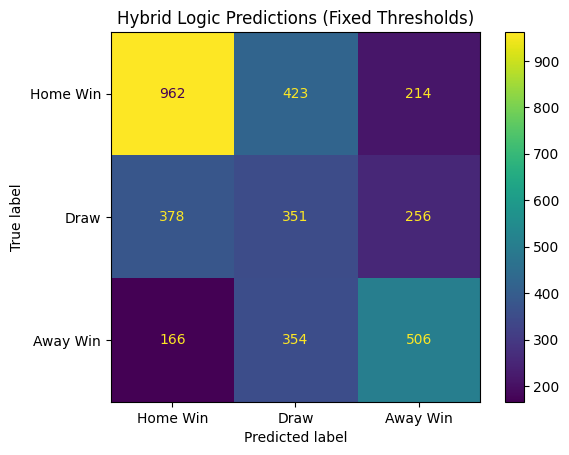

Accuracy for Home Win: 60.16%
Accuracy for Draw: 35.63%
Accuracy for Away Win: 49.32%

Overall Accuracy: 50.39%
Precision for Home Win: 63.88%
Precision for Draw: 31.12%
Precision for Away Win: 51.84%

Regression Metrics:
Root Mean Squared Error (RMSE): 0.6020
Sign Accuracy: 70.91%
Top-2 Accuracy: 80.69%
Weighted F1 Score: 50.88%


In [20]:
clf_model.eval()
reg_model.eval()
results = []
all_preds, all_targets = [], []

with torch.no_grad():
    preds, probs = clf_model.predict(X_test_tensor)
    reg_preds = reg_model(X_test_tensor).squeeze()

    for i in range(len(y_test_tensor)):
        class_pred = preds[i].item()
        goal_diff_pred = reg_preds[i].item()
        ph, pdr, pa = probs[i][0].item(), probs[i][1].item(), probs[i][2].item()
        actual = y_test_tensor[i].item()

        final_pred = resolve_prediction(class_pred, goal_diff_pred, ph, pdr, pa)
        was_overridden = (final_pred != class_pred)

        row_data = data.iloc[split_idx + i]

        results.append({
            "match_index": split_idx + i,
            "actual_result": actual,
            "predicted_result": final_pred,
            "original_classifier_output": class_pred,
            "override": was_overridden,
            "goal_diff": int(row_data['goal_diff']),
            "goal_diff_pred": goal_diff_pred,
            "model_prob_home": ph,
            "model_prob_draw": pdr,
            "model_prob_away": pa,
            "implied_prob_home": row_data['prob_home_win'],
            "implied_prob_draw": row_data['prob_draw'],
            "implied_prob_away": row_data['prob_away_win']
        })

        all_preds.append(final_pred)
        all_targets.append(actual)


# Confusion matrix
cm = confusion_matrix(all_targets, all_preds)
class_labels = ['Home Win', 'Draw', 'Away Win']
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels).plot()
plt.title("Hybrid Logic Predictions (Fixed Thresholds)")
plt.show()

# Classification metrics
class_accuracies = cm.diagonal() / cm.sum(axis=1)
for idx, class_acc in enumerate(class_accuracies):
    print(f"Accuracy for {class_labels[idx]}: {class_acc:.2%}")

overall_acc = np.mean(np.array(all_preds) == np.array(all_targets))
print(f"\nOverall Accuracy: {overall_acc:.2%}")

precisions = precision_score(all_targets, all_preds, average=None, zero_division=0)
for idx, prec in enumerate(precisions):
    print(f"Precision for {class_labels[idx]}: {prec:.2%}")

# Regression metrics
true_goal_diffs = data.iloc[split_idx:]['goal_diff'].values.astype(float)
predicted_goal_diffs = [row['goal_diff_pred'] for row in results]

rmse = root_mean_squared_error(true_goal_diffs, predicted_goal_diffs)
r2 = r2_score(true_goal_diffs, predicted_goal_diffs)
sign_accuracy = np.mean(np.sign(predicted_goal_diffs) == np.sign(true_goal_diffs))

print(f"\nRegression Metrics:")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Sign Accuracy: {sign_accuracy:.2%}")
top2_correct = 0
for i, prob_vector in enumerate(probs):
    top2 = np.argsort(prob_vector.numpy())[::-1][:2]
    if y_test_tensor[i].item() in top2:
        top2_correct += 1
top2_acc = top2_correct / len(y_test_tensor)
print(f"Top-2 Accuracy: {top2_acc:.2%}")
# Save results

weighted_f1 = f1_score(all_targets, all_preds, average='weighted')
print(f"Weighted F1 Score: {weighted_f1:.2%}")

results_df = pd.DataFrame(results)
results_df.to_csv("../outputs/final_network_predictions.csv", index=False)

# Vs Baselines

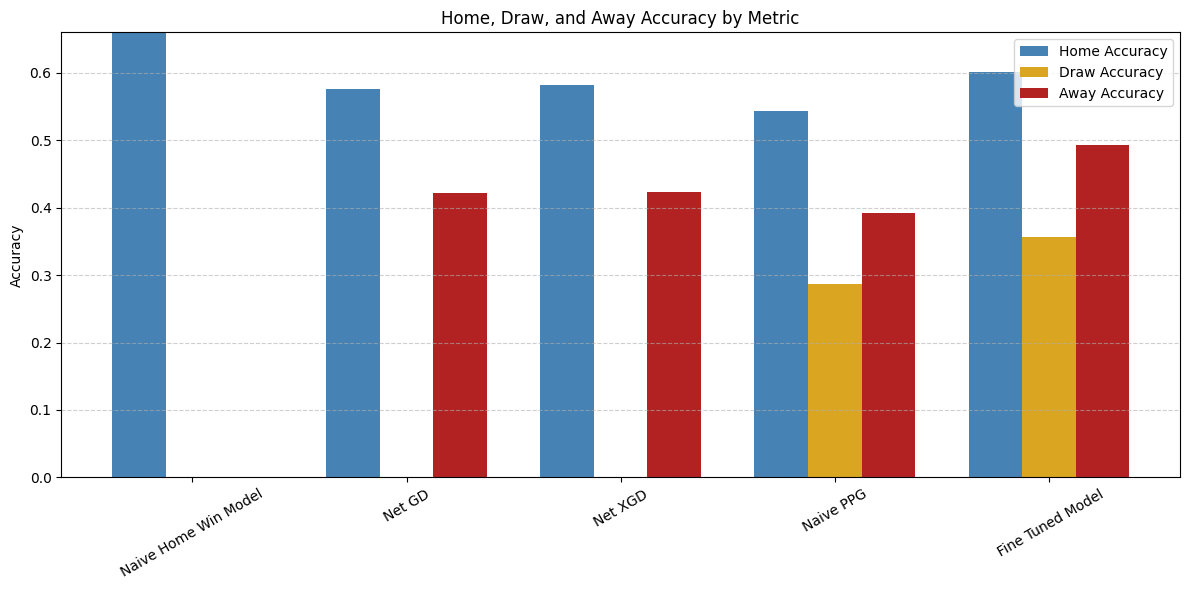

In [29]:
metrics = ['Naive Home Win Model', 'Net GD', 'Net XGD', 'Naive PPG', ' Fine Tuned Model']

model_home_accuracy = class_accuracies[0]
model_draw_accuracy = class_accuracies[1]
model_away_accuracy = class_accuracies[2]

home_accuracies = [100, home_netGDaccuracy, home_netXGaccuracy, home_ppgaccuracy, model_home_accuracy]  
away_accuracies = [0, away_netGDaccuracy, away_netXGaccuracy, away_ppgaccuracy, model_away_accuracy]  
draw_accuracies = [0, 0, 0, draw_ppgaccuracy, model_draw_accuracy]  

x = np.arange(len(metrics))
bar_width = 0.25

plt.figure(figsize=(12, 6))

plt.bar(x - bar_width, home_accuracies, width=bar_width, label='Home Accuracy', color='steelblue')
plt.bar(x, draw_accuracies, width=bar_width, label='Draw Accuracy', color='goldenrod')
plt.bar(x + bar_width, away_accuracies, width=bar_width, label='Away Accuracy', color='firebrick')

plt.xticks(x, metrics, rotation=30)
plt.ylim(0.0, 0.66)
plt.ylabel('Accuracy')
plt.title('Home, Draw, and Away Accuracy by Metric')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## Bettings Odds on Test Set

Betting Odds Evaluation
Overall Accuracy: 53.27%
Accuracy for Home Win: 83.80%
Accuracy for Draw: 0.30%
Accuracy for Away Win: 56.53%
Precision for Home Win: 54.87%
Precision for Draw: 16.67%
Precision for Away Win: 50.43%


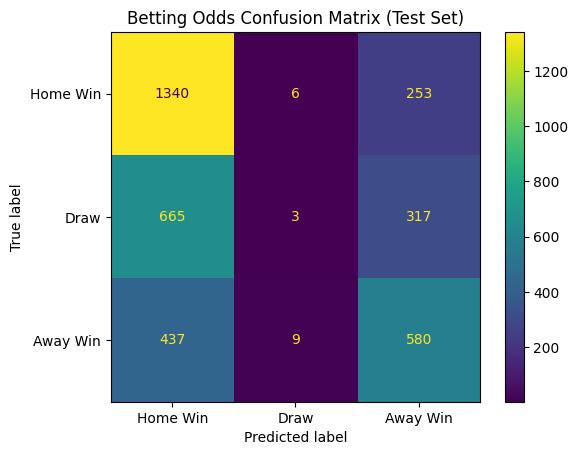

In [42]:
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

# Assumes 'data' contains the full dataset and 'split_idx' defines the train/test boundary
# Columns required: 'prob_home_win', 'prob_draw', 'prob_away_win'

# Extract test portion
test_data = data.iloc[split_idx:].copy()

# Map most likely outcome to class index: 0 = Home Win, 1 = Draw, 2 = Away Win
prob_to_class = {
    'prob_home_win': 0,
    'prob_draw': 1,
    'prob_away_win': 2
}

# Select the column with the highest implied probability
test_data['predicted_result'] = test_data[['prob_home_win', 'prob_draw', 'prob_away_win']].idxmax(axis=1).map(prob_to_class)
test_data['actual_result'] = y_test.values  # ensure alignment

# Compute overall accuracy
accuracy = accuracy_score(test_data['actual_result'], test_data['predicted_result'])

# Compute confusion matrix
cm = confusion_matrix(test_data['actual_result'], test_data['predicted_result'])
class_labels = ['Home Win', 'Draw', 'Away Win']

# Compute precision and per-class accuracy (recall)
precisions = precision_score(test_data['actual_result'], test_data['predicted_result'], average=None, zero_division=0)
recalls = cm.diagonal() / cm.sum(axis=1)

# Print metrics
print(f"Betting Odds Evaluation")
print(f"Overall Accuracy: {accuracy:.2%}")
for idx, label in enumerate(class_labels):
    print(f"Accuracy for {label}: {recalls[idx]:.2%}")
for idx, label in enumerate(class_labels):
    print(f"Precision for {label}: {precisions[idx]:.2%}")

# Plot confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels).plot()
plt.title("Betting Odds Confusion Matrix (Test Set)")
plt.show()

## Betting with 0< EV

In [36]:
# Load predictions and odds
results_df = pd.read_csv("../outputs/final_network_predictions.csv")

# Initialize tracking
winnings = []
stakes = []
bets_placed = 0
correct_bets = 0

# Per-class tracking
bet_counts = {0: 0, 1: 0, 2: 0}
stake_totals = {0: 0.0, 1: 0.0, 2: 0.0}
returns = {0: 0.0, 1: 0.0, 2: 0.0}
labels = {0: "Home Win", 1: "Draw", 2: "Away Win"}

# Simulate betting
for _, row in results_df.iterrows():
    actual = int(row['actual_result'])
    pred = int(row['predicted_result'])

    model_probs = [row['model_prob_home'], row['model_prob_draw'], row['model_prob_away']]
    decimal_odds = [
        1.0 / max(row['implied_prob_home'], 1e-6),
        1.0 / max(row['implied_prob_draw'], 1e-6),
        1.0 / max(row['implied_prob_away'], 1e-6),
    ]

    pred_model_prob = model_probs[pred]
    pred_odds = decimal_odds[pred]

    ev = (pred_model_prob * pred_odds) - 1

    if ev > 0:
        stake = 1
        bets_placed += 1
        bet_counts[pred] += 1
        stake_totals[pred] += stake
        stakes.append(stake)

        if pred == actual:
            payout = pred_odds * stake
            winnings.append(payout)
            correct_bets += 1
            returns[pred] += payout
        else:
            winnings.append(0)

# Aggregate results
total_staked = sum(stakes)
total_returned = sum(winnings)
net_profit = total_returned - total_staked
roi = net_profit / total_staked if total_staked > 0 else 0
win_rate = correct_bets / bets_placed if bets_placed > 0 else 0

# Print overall summary
print(f"Betting Simulation Summary")
print(f"Bets placed: {bets_placed} / {len(results_df)}")
print(f"Correct bets: {correct_bets}")
print(f"Win rate: {win_rate:.2%}")
print(f"Total staked: £{total_staked:.2f}")
print(f"Total returned: £{total_returned:.2f}")
print(f"Net profit: £{net_profit:.2f}")
print(f"ROI: {roi:.2%}\n")

# Create breakdown table
breakdown_data = []
total_bets = sum(bet_counts.values())
total_stake_all = sum(stake_totals.values())
total_return_all = sum(returns.values())
roi_total = (total_return_all - total_stake_all) / total_stake_all if total_stake_all > 0 else None

for i in range(3):
    staked = stake_totals[i]
    returned = returns[i]
    roi_outcome = (returned - staked) / staked if staked > 0 else None
    breakdown_data.append({
        "Outcome": labels[i],
        "Bets Placed": bet_counts[i],
        "Total Staked (£)": round(staked, 2),
        "Total Returned (£)": round(returned, 2),
        "ROI": f"{roi_outcome:.2%}" if roi_outcome is not None else "N/A"
    })

# Add totals row
breakdown_data.append({
    "Outcome": "Total",
    "Bets Placed": total_bets,
    "Total Staked (£)": round(total_stake_all, 2),
    "Total Returned (£)": round(total_return_all, 2),
    "ROI": f"{roi_total:.2%}" if roi_total is not None else "N/A"
})

breakdown1_df = pd.DataFrame(breakdown_data)
print(breakdown1_df)
breakdown_df.to_csv("../outputs/betting_simulation_breakdown.csv", index=False)

Betting Simulation Summary
Bets placed: 2811 / 3610
Correct bets: 1335
Win rate: 47.49%
Total staked: £2811.00
Total returned: £3002.56
Net profit: £191.56
ROI: 6.81%

    Outcome  Bets Placed  Total Staked (£)  Total Returned (£)     ROI
0  Home Win          911             911.0              967.93   6.25%
1      Draw         1098            1098.0             1218.83  11.00%
2  Away Win          802             802.0              815.80   1.72%
3     Total         2811            2811.0             3002.56   6.81%


## Refined Betting?

In [ ]:
results_df = pd.read_csv("../outputs/final_network_predictions.csv")

draw_ev_thresholds = [0.0, 0.02, 0.05]
draw_prob_thresholds = [0.25, 0.3, 0.35]

home_ev_thresholds = [0.02, 0.05, 0.1]
home_prob_thresholds = [0.5, 0.55, 0.6]

away_ev_thresholds = [0.05, 0.1, 0.15]
away_prob_thresholds = [0.55, 0.6, 0.65]

results = []

for draw_ev, draw_prob, home_ev, home_prob, away_ev, away_prob in itertools.product(
        draw_ev_thresholds, draw_prob_thresholds,
        home_ev_thresholds, home_prob_thresholds,
        away_ev_thresholds, away_prob_thresholds):

    winnings = []
    stakes = []
    correct_bets = 0
    bets_placed = 0

    for _, row in results_df.iterrows():
        actual = int(row['actual_result'])
        pred = int(row['predicted_result'])

        model_probs = [row['model_prob_home'], row['model_prob_draw'], row['model_prob_away']]
        implied_probs = [row['implied_prob_home'], row['implied_prob_draw'], row['implied_prob_away']]
        decimal_odds = [1.0 / max(p, 1e-6) for p in implied_probs]

        model_prob = model_probs[pred]
        pred_odds = decimal_odds[pred]
        ev = (model_prob * pred_odds) - 1

        bet = False
        if pred == 1 and ev > draw_ev and model_prob > draw_prob:
            bet = True
        elif pred == 0 and ev > home_ev and model_prob > home_prob:
            bet = True
        elif pred == 2 and ev > away_ev and model_prob > away_prob:
            bet = True

        if bet:
            stake = 1
            stakes.append(stake)
            bets_placed += 1
            if pred == actual:
                winnings.append(pred_odds * stake)
                correct_bets += 1
            else:
                winnings.append(0)

    total_staked = sum(stakes)
    total_returned = sum(winnings)
    net_profit = total_returned - total_staked
    roi = net_profit / total_staked if total_staked > 0 else 0
    win_rate = correct_bets / bets_placed if bets_placed > 0 else 0

    results.append({
        "draw_ev_thresh": draw_ev,
        "draw_prob_thresh": draw_prob,
        "home_ev_thresh": home_ev,
        "home_prob_thresh": home_prob,
        "away_ev_thresh": away_ev,
        "away_prob_thresh": away_prob,
        "bets_placed": bets_placed,
        "correct_bets": correct_bets,
        "win_rate": round(win_rate, 4),
        "roi": round(roi, 4),
        "net_profit": round(net_profit, 2),
        "total_staked": total_staked,
        "total_returned": total_returned
    })

# Save results
grid_df = pd.DataFrame(results)
grid_df = grid_df.sort_values(by="roi", ascending=False)
grid_df.to_csv("../outputs/strategy_grid_optimization.csv", index=False)

print("Grid search complete. Results saved to strategy_grid_optimization.csv.")

In [35]:
results_df = pd.read_csv("../outputs/final_network_predictions.csv")

draw_ev_thresh = 0.02
draw_prob_thresh = 0.35
home_ev_thresh = 0.05
home_prob_thresh = 0.60
away_ev_thresh = 0.10
away_prob_thresh = 0.60

winnings = []
stakes = []
bets_placed = 0
correct_bets = 0

bet_counts = {0: 0, 1: 0, 2: 0}
stake_totals = {0: 0.0, 1: 0.0, 2: 0.0}
returns = {0: 0.0, 1: 0.0, 2: 0.0}
labels = {0: "Home Win", 1: "Draw", 2: "Away Win"}

# Simulate strategy
for _, row in results_df.iterrows():
    actual = int(row['actual_result'])
    pred = int(row['predicted_result'])

    model_probs = [row['model_prob_home'], row['model_prob_draw'], row['model_prob_away']]
    implied_probs = [row['implied_prob_home'], row['implied_prob_draw'], row['implied_prob_away']]
    decimal_odds = [1.0 / max(p, 1e-6) for p in implied_probs]

    model_prob = model_probs[pred]
    pred_odds = decimal_odds[pred]
    ev = (model_prob * pred_odds) - 1

    bet = False
    if pred == 1 and ev > draw_ev_thresh and model_prob > draw_prob_thresh:
        bet = True
    elif pred == 0 and ev > home_ev_thresh and model_prob > home_prob_thresh:
        bet = True
    elif pred == 2 and ev > away_ev_thresh and model_prob > away_prob_thresh:
        bet = True

    if bet:
        stake = 1
        bets_placed += 1
        bet_counts[pred] += 1
        stake_totals[pred] += stake
        stakes.append(stake)

        if pred == actual:
            payout = pred_odds * stake
            winnings.append(payout)
            correct_bets += 1
            returns[pred] += payout
        else:
            winnings.append(0)

total_staked = sum(stakes)
total_returned = sum(winnings)
net_profit = total_returned - total_staked
roi = net_profit / total_staked if total_staked > 0 else 0
win_rate = correct_bets / bets_placed if bets_placed > 0 else 0

breakdown_data = []
for i in range(3):
    staked = stake_totals[i]
    returned = returns[i]
    roi_outcome = (returned - staked) / staked if staked > 0 else None
    breakdown_data.append({
        "Outcome": labels[i],
        "Bets Placed": bet_counts[i],
        "Total Staked (£)": round(staked, 2),
        "Total Returned (£)": round(returned, 2),
        "ROI": f"{roi_outcome:.2%}" if roi_outcome is not None else "N/A"
    })

breakdown_data.append({
    "Outcome": "Total",
    "Bets Placed": bets_placed,
    "Total Staked (£)": round(total_staked, 2),
    "Total Returned (£)": round(total_returned, 2),
    "ROI": f"{roi:.2%}"
})

breakdown_df = pd.DataFrame(breakdown_data)
print(breakdown_df)
breakdown_df.to_csv("../outputs/refined_strategy_breakdown.csv", index=False)

    Outcome  Bets Placed  Total Staked (£)  Total Returned (£)     ROI
0  Home Win          388             388.0              421.54   8.64%
1      Draw          842             842.0              978.33  16.19%
2  Away Win          210             210.0              217.15   3.40%
3     Total         1440            1440.0             1617.01  12.29%


## Class Seperability

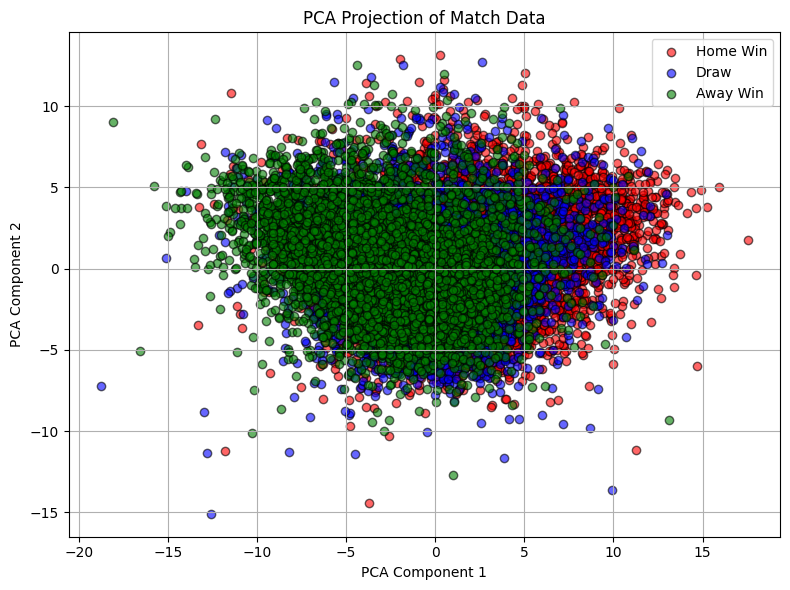

In [40]:
file_path = "../processed_data/features.csv"
data = pd.read_csv(file_path)

def is_misleading_xg(row):
    xg_diff = row['team_a_xg'] - row['team_b_xg']
    if xg_diff >= 1.0 and row['match_result'] == 2:
        return True
    if xg_diff <= -1.0 and row['match_result'] == 0:
        return True
    return False

data = data[~data.apply(is_misleading_xg, axis=1)].reset_index(drop=True)

X = data.drop(columns=[
    'home_team_name', 'away_team_name',
    'home_team_goal_count', 'away_team_goal_count',
    'match_result', 'date_GMT', 'team_a_xg', 'team_b_xg', 
] + [col for col in data.columns if 'yellow' in col or 'red' in col])

y_class = data['match_result']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
colors = ['red', 'blue', 'green']
labels = ['Home Win', 'Draw', 'Away Win']

for class_index, color, label in zip([0, 1, 2], colors, labels):
    plt.scatter(X_pca[y_class == class_index, 0], X_pca[y_class == class_index, 1],
                label=label, alpha=0.6, c=color, edgecolors='k')

plt.title('PCA Projection of Match Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("pca_projection.png", dpi=300)
plt.show()